In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson # 辛普森积分
from scipy.integrate import quad # 自适应积分(基于高斯-勒让德积分法)
from matplotlib.animation import FuncAnimation # 动画
from matplotlib.animation import PillowWriter  # 保存为 gif
from IPython.display import HTML # 在 Jupyter Notebook 中显示动画


class MotionControl:
    # 初始化
    def __init__(self, f, df, curve_name=None, finding_method=None):
        self.f = f
        self.df = df
        self.curve_name = curve_name if curve_name is not None else 'The Curve'
        self.finding_method = finding_method if finding_method in ['Newton', 'Bisection'] else None
    
    # setters
    def set_find_method(self, method):
        self.finding_method = method if method in ['Newton', 'Bisection'] else None
    def set_curve_name(self, name):
        self.curve_name = name
    
    # 计算路径长度
    def path_length(self, t1, t2):
        # 定义模长函数  
        def integrand(t):
            return np.linalg.norm(self.df(t))
        # 使用自适应积分计算路径长度  
        length, _ = quad(integrand, t1, t2)
        return length   
    
    # 使用指定方法法找到 t^*(s)
    def find_t_star(self, s, tol=1e-6, method=None):
        # self.finding_method = method if method in ['Newton', 'Bisection'] else None
        m = method if method in ['Newton', 'Bisection'] else self.finding_method
        
        if m == 'Newton': # 牛顿法
            return self.find_t_star_newton(s, tol)
        elif m == 'Bisection': # 二分
            return self.find_t_star_bisection(s, tol)
        else:
            return self.find_t_star_newton(s, tol) # 默认: 牛顿法
        
    # 牛顿法
    def find_t_star_newton(self, s, tol):
        total_length = self.path_length(0, 1)
        t = 0.5
        while True:
            length_t = self.path_length(0, t)
            F_t = length_t / total_length - s
            if abs(F_t) < tol:
                break
            df_t = np.linalg.norm(self.df(t))
            F_prime_t = df_t / total_length
            t -= F_t / F_prime_t
            t = max(0, min(1, t))
        # return round(t, 3)
        return t
    
    # 二分法
    def find_t_star_bisection(self, s, tol):
        total_length = self.path_length(0, 1)
        a, b = 0, 1
        while True:
            t = (a + b) / 2
            length_t = self.path_length(0, t)
            F_t = length_t / total_length - s
            if abs(F_t) < tol:
                break
            if F_t > 0:
                b = t
            else:
                a = t
        # return round(t, 3)
        return t
    
    # 求 n 等分点
    def find_n_equal_segments(self, n):
        t_values = []
        for i in range(n + 1):
            s = i / n
            t_star = self.find_t_star(s)
            t_values.append(t_star)
        return t_values
    
    # 绘制函数曲线和n等分点
    def plot_n_equal_segments(self, n):
        t_values = self.find_n_equal_segments(n)
        t = np.linspace(0, 1, 100)
        points = np.array([self.f(ti) for ti in t])
        plt.plot(points[:, 0], points[:, 1], label=self.curve_name, color='blue')
        for t_star in t_values:
            point = self.f(t_star)
            plt.plot(point[0], point[1], 'ro')
            plt.text(point[0], point[1], f'({point[0]:.2f}, {point[1]:.2f})', fontsize=8, ha='right')
        plt.title(f'{self.curve_name} with {n} Equal Segments')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.legend()
        plt.grid()
        plt.axis('equal')
        plt.show()
    
    # 绘制函数曲线和等分t的点
    def plot_t_equal_segments(self, n):
        t_values = np.linspace(0, 1, n + 1)
        t = np.linspace(0, 1, 100)
        points = np.array([self.f(ti) for ti in t])
        plt.plot(points[:, 0], points[:, 1], label=self.curve_name, color='blue')
        for t_star in t_values:
            point = self.f(t_star)
            plt.plot(point[0], point[1], 'ro')
            plt.text(point[0], point[1], f'({point[0]:.2f}, {point[1]:.2f})', fontsize=8, ha='right')
        plt.title(f'{self.curve_name} with {n} Equal t Segments')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.legend()
        plt.grid()
        plt.axis('equal')
        plt.show()
    
    # 左等分t，右等分s(对比图)
    def plot_t_left_s_right(self, n):
        t_values_t = np.linspace(0, 1, n + 1)
        t_values_s = self.find_n_equal_segments(n)
        t = np.linspace(0, 1, 100)
        points = np.array([self.f(ti) for ti in t])
        # 创建画布
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        # 左图
        ax[0].plot(points[:, 0], points[:, 1], label=self.curve_name, color='blue')
        for t_star in t_values_t:
            point = self.f(t_star)
            ax[0].plot(point[0], point[1], 'ro')
            ax[0].text(point[0], point[1], f'({point[0]:.2f}, {point[1]:.2f})', fontsize=8, ha='right')
        ax[0].set_title(f'{self.curve_name} with {n} Equal t Segments')
        ax[0].set_xlabel('X-axis')
        ax[0].set_ylabel('Y-axis')
        ax[0].legend()
        ax[0].grid()
        ax[0].axis('equal')
        # 右图
        ax[1].plot(points[:, 0], points[:, 1], label=self.curve_name, color='blue')
        for t_star in t_values_s:
            point = self.f(t_star)
            ax[1].plot(point[0], point[1], 'ro')
            ax[1].text(point[0], point[1], f'({point[0]:.2f}, {point[1]:.2f})', fontsize=8, ha='right')
        ax[1].set_title(f'{self.curve_name} with {n} Equal s Segments')
        ax[1].set_xlabel('X-axis')
        ax[1].set_ylabel('Y-axis')
        ax[1].legend()
        ax[1].grid()
        ax[1].axis('equal')
        plt.show()
        
        
    # 动画
    def create_animate(self, n=None, frames=None, interval=50, show=True):
        """  
        n: 指定 n ，则按等分点数播放(n帧)  
            否则，按时间步长播放(可选传入帧数，默认100帧)  
        frames: 指定帧数  
        interval: 每帧间隔时间  
        """  
        t_values = self.find_n_equal_segments(n)  
        fig, ax = plt.subplots()  
        
        # 计算曲线的点  
        t = np.linspace(0, 1, 100)  
        points = np.array([self.f(ti) for ti in t])  
        
        # 设置坐标轴范围  
        # 边距为图像的额外 20%
        extra_scale = 0.2
        extra_x = (points[:, 0].max() - points[:, 0].min()) * extra_scale
        extra_y = (points[:, 1].max() - points[:, 1].min()) * extra_scale
        
        ax.set_xlim(points[:, 0].min() - extra_x, points[:, 0].max() + extra_x)
        ax.set_ylim(points[:, 1].min() - extra_y, points[:, 1].max() + extra_y)
        
        ax.set_aspect('equal')  
        ax.set_title(f'Ball Moving along {self.curve_name}')  
        
        # 绘制曲线  
        ax.plot(points[:, 0], points[:, 1], label=self.curve_name, color='blue')  
        ball, = ax.plot([], [], 'ro', markersize=5)  
        ax.grid(True)  
        
        if n is not None:  # 按等分点数播放  
            frames = n  
            def animate(i):  
                t = t_values[i]  
                point = self.f(t)  
                ball.set_data([point[0]], [point[1]])  
                return ball,  
        else:  # 按时间步长播放
            frames = frames if isinstance(frames, int) else 100  
            def animate(i):  
                t = i / frames  
                point = self.f(t)  
                ball.set_data([point[0]], [point[1]])  
                return ball,  

        self.ani = FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)  

        if not show:  
            plt.close()    
        return HTML(self.ani.to_jshtml())  
        
    
    # 将动画保存为gif
    def save_gif(self, filename):
        if hasattr(self, 'ani'):
            self.ani.save(filename, writer=PillowWriter(fps=20))
        else:
            print(f'No animation to save.\n Please create an animation first.\nuse function "create_animate()"')
        
    

In [30]:
# 0.1 定义函数，如三次贝塞尔曲线

p0 = np.array([0.5, 1.5])
p1 = np.array([0.6, 1.6])
p2 = np.array([2, 2])
p3 = np.array([0, 0])

bezier = lambda t: (1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 + 3 * (1 - t) * t**2 * p2 + t**3 * p3
bezier_prime = lambda t: 3 * (1 - t)**2 * (p1 - p0) + 6 * (1 - t) * t * (p2 - p1) + 3 * t**2 * (p3 - p2)

# 0.2. 初始化 MotionControl 类
motion_control = MotionControl(bezier, bezier_prime)

# 1. 计算路径长度
length = motion_control.path_length(0, 1)
print(f'Length of Bezier Curve: {length}')



Length of Bezier Curve: 2.495246747514833


In [31]:
# 2. 使用牛顿法找到 t^*(s)
motion_control.set_find_method('Newton') # 
# motion_control.set_find_method('Bisection')

t_star = motion_control.find_t_star(0.5)
print(f't^*(0.5) = {t_star}')

t^*(0.5) = 0.8005937719507381


5 Equal Segments: [0, 0.43167605852694085, 0.732898125267733, 0.8532398203894455, 0.9352945080850739, 1]


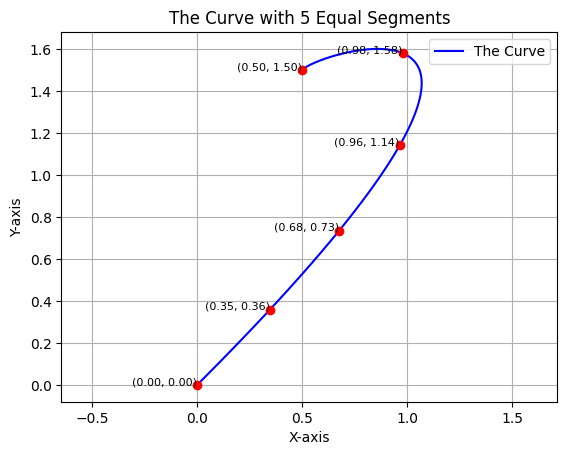

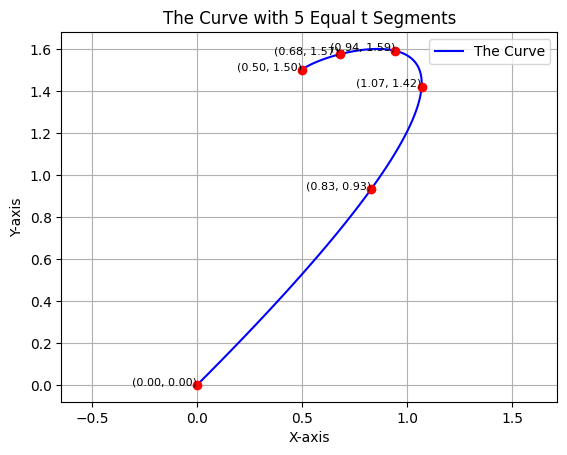

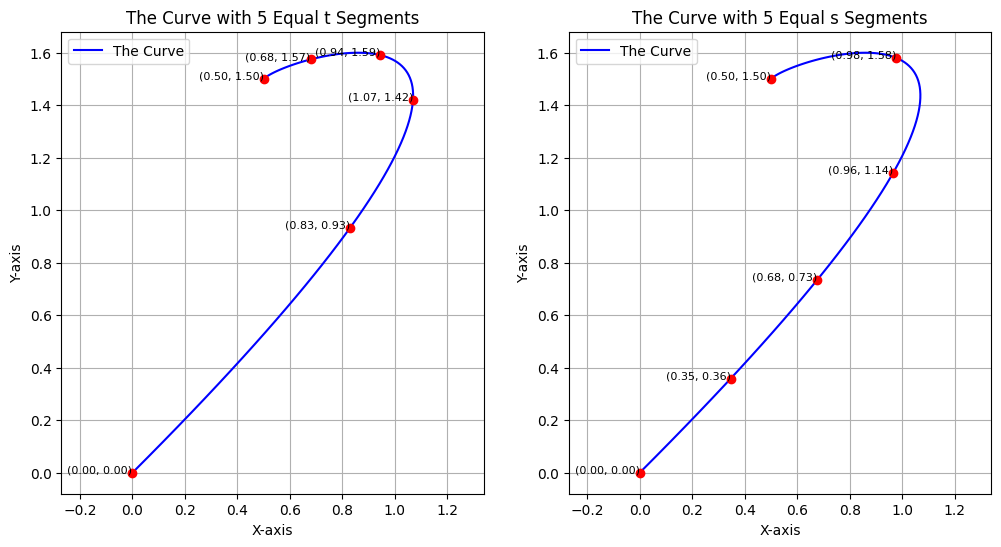

In [32]:
# 3.1 求 n 等分点
t_values = motion_control.find_n_equal_segments(5)
print(f'5 Equal Segments: {t_values}')

# 3.2 绘制函数曲线和等分点
motion_control.plot_n_equal_segments(5)

# n等分 t 的点
motion_control.plot_t_equal_segments(5)

motion_control.plot_t_left_s_right(5)

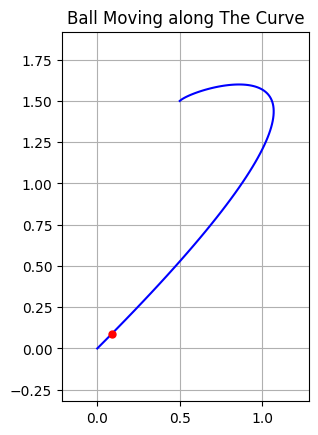

In [33]:
# 4. 略 
# 见 <步骤2> 
# set_find_method('Newton') 或 set_find_method('Bisection')

# 5. 动画
# 5.1 按等分点数播放
motion_control.create_animate(n=20, show=True)



In [34]:
# 保存为 gif
motion_control.save_gif('20-equal-segments bezier curve.gif')

# 5.2 按时间步长播放
# motion_control.create_animate(frames=100, show=False)
# motion_control.save_gif('100-frames bezier curve.gif')

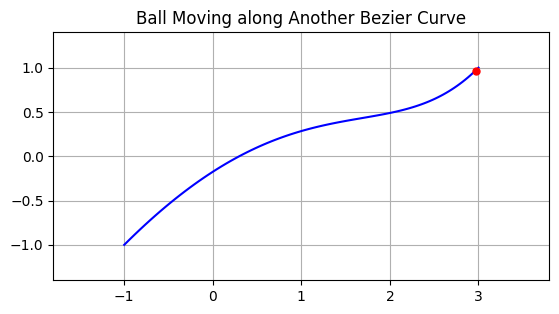

In [35]:
# 6. 使用另外不同的贝塞尔曲线
# 原始数据为··········································································································
# p0 = np.array([0.5, 1.5])
# p1 = np.array([0.6, 1.6])
# p2 = np.array([2, 2])
# p3 = np.array([0, 0])

p0 = np.array([-1, -1])
p1 = np.array([1, 1])
p2 = np.array([2, 0])
p3 = np.array([3, 1])

bezier = lambda t: (1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 + 3 * (1 - t) * t**2 * p2 + t**3 * p3

bezier_prime = lambda t: 3 * (1 - t)**2 * (p1 - p0) + 6 * (1 - t) * t * (p2 - p1) + 3 * t**2 * (p3 - p2)

motion_control = MotionControl(bezier, bezier_prime)
motion_control.set_curve_name('Another Bezier Curve')
motion_control.create_animate(n=100, show=True)

In [36]:
motion_control.save_gif('100-equal-segments another bezier curve.gif')

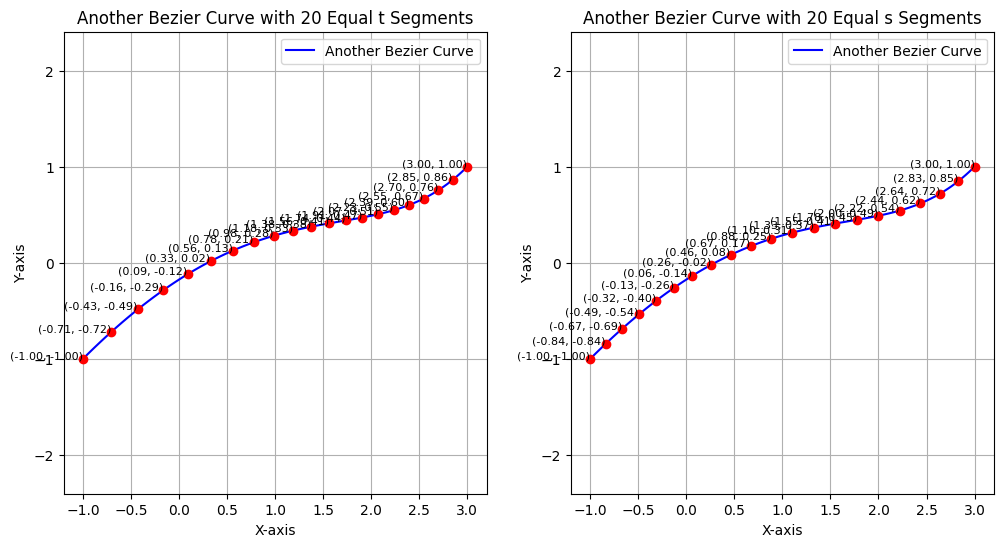

In [37]:
# motion_control.plot_n_equal_segments(20)
# motion_control.plot_t_equal_segments(20)
motion_control.plot_t_left_s_right(20)


$$
\begin{align*}
& f(x) = x \\
& f(x) = x^{\frac{1}{3}} \\
& f(x) = x^2 \\
& f(x) = \sin x\pi/2 \\
& f(x) = 1/2 + 1/2 * \sin (2x-1)\pi/2 \\
\end{align*}
$$

In [38]:
# 7. 使用其他曲线
# 7.1 f(x) = x
f = lambda t: np.array([t, t])
df = lambda t: np.array([1, 1])

motion_control = MotionControl(f, df, 'f(x) = x')
motion_control.create_animate(n=20, show=False)
motion_control.save_gif('20-equal-segments of extra f1.gif')

In [39]:
# 7.2 f(x) = x^{\frac{1}{3}}
f = lambda t: np.array([t, t**(1/3)])
# df = lambda t: np.array([1, 1/3 * t**(-2/3)]) # 会出现 "除零错误" !!!
# df = lambda t: np.array([1, 1/3 * t**(1/3 - 1) if t != 0 else np.inf]) # 防止除零错误 ver1 (inf 容易导致后续计算出错)
df = lambda t: np.array([1, 1/3 * (t**(-2/3)) if t != 0 else 1e6]) # 防止除零错误 ver2

motion_control = MotionControl(f, df, 'f(x) = x^(1/3)')
motion_control.create_animate(n=20, show=False)
motion_control.save_gif('20-equal-segments of extra f2.gif')

In [40]:
# 7.3 f(x) = x^2
f = lambda t: np.array([t, t**2])
df = lambda t: np.array([1, 2*t])

motion_control = MotionControl(f, df, 'f(x) = x^2')
motion_control.create_animate(n=20, show=False)
motion_control.save_gif('20-equal-segments of extra f3.gif')

In [41]:
# 7.4 f(x) = \sin x\pi/2
f = lambda t: np.array([t, np.sin(t * np.pi / 2)])
df = lambda t: np.array([1, np.pi / 2 * np.cos(t * np.pi / 2)])

motion_control = MotionControl(f, df, 'f(x) = sin(xπ/2)')
motion_control.create_animate(n=20, show=False)
motion_control.save_gif('20-equal-segments of extra f4.gif')

In [42]:
# 7.5 f(x) = 1/2 + 1/2 * \sin (2x-1)\pi/2
f = lambda t: np.array([t, 0.5 + 0.5 * np.sin((2*t - 1) * np.pi / 2)])
df = lambda t: np.array([1, np.pi / 2 * np.cos((2*t - 1) * np.pi / 2)])

motion_control = MotionControl(f, df, 'f(x) = 1/2 + 1/2 * sin((2x-1)π/2)')
motion_control.create_animate(n=20, show=False)
motion_control.save_gif('20-equal-segments of extra f5.gif')

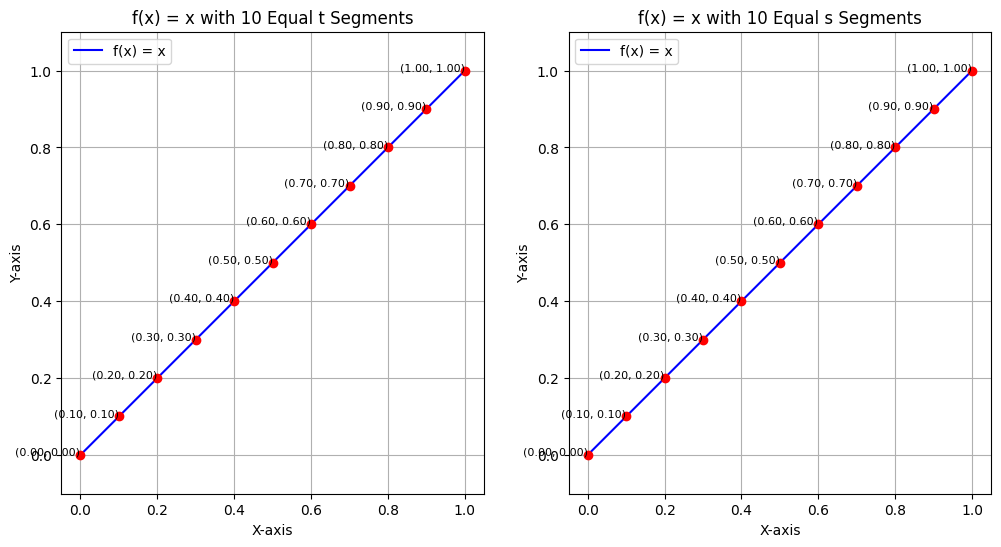

In [43]:
f = lambda t: np.array([t, t])
df = lambda t: np.array([1, 1])

motion_control = MotionControl(f, df, 'f(x) = x')
# motion_control.plot_n_equal_segments(10)
# motion_control.plot_t_equal_segments(10)
motion_control.plot_t_left_s_right(10)

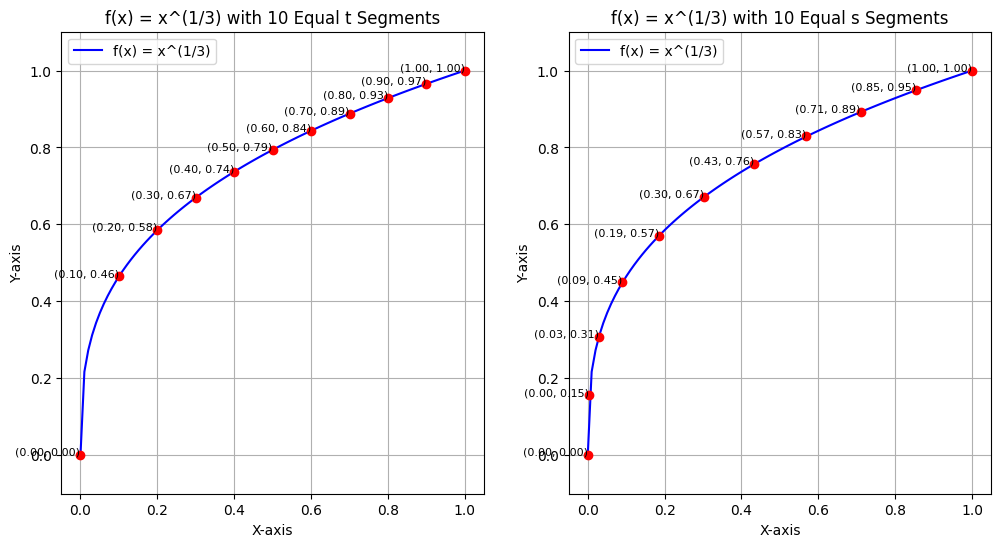

In [44]:
f = lambda t: np.array([t, t**(1/3)])
df = lambda t: np.array([1, 1/3 * (t**(-2/3)) if t != 0 else 1e6]) # 防止除零错误 ver2

motion_control = MotionControl(f, df, 'f(x) = x^(1/3)')
# motion_control.plot_n_equal_segments(10)
# motion_control.plot_t_equal_segments(10)
motion_control.plot_t_left_s_right(10)

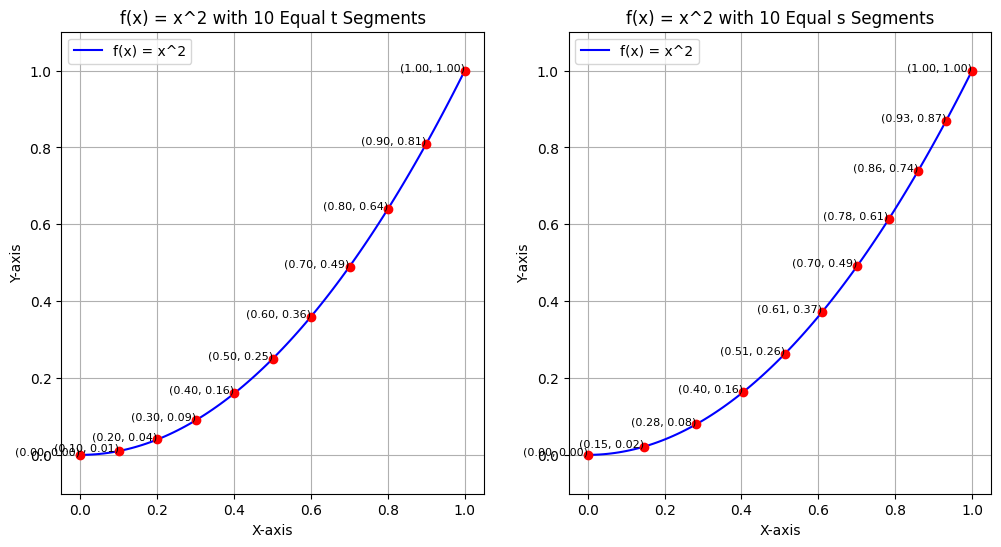

In [45]:
f = lambda t: np.array([t, t**2])
df = lambda t: np.array([1, 2*t])

motion_control = MotionControl(f, df, 'f(x) = x^2')
# motion_control.plot_n_equal_segments(10)
# motion_control.plot_t_equal_segments(10)
motion_control.plot_t_left_s_right(10)

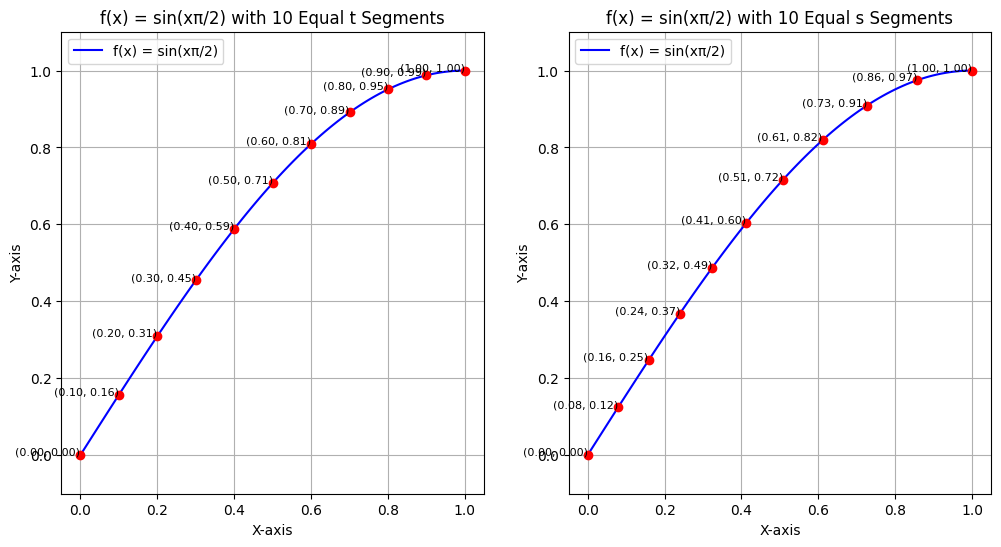

In [46]:
f = lambda t: np.array([t, np.sin(t * np.pi / 2)])
df = lambda t: np.array([1, np.pi / 2 * np.cos(t * np.pi / 2)])

motion_control = MotionControl(f, df, 'f(x) = sin(xπ/2)')
# motion_control.plot_n_equal_segments(10)
# motion_control.plot_t_equal_segments(10)
motion_control.plot_t_left_s_right(10)

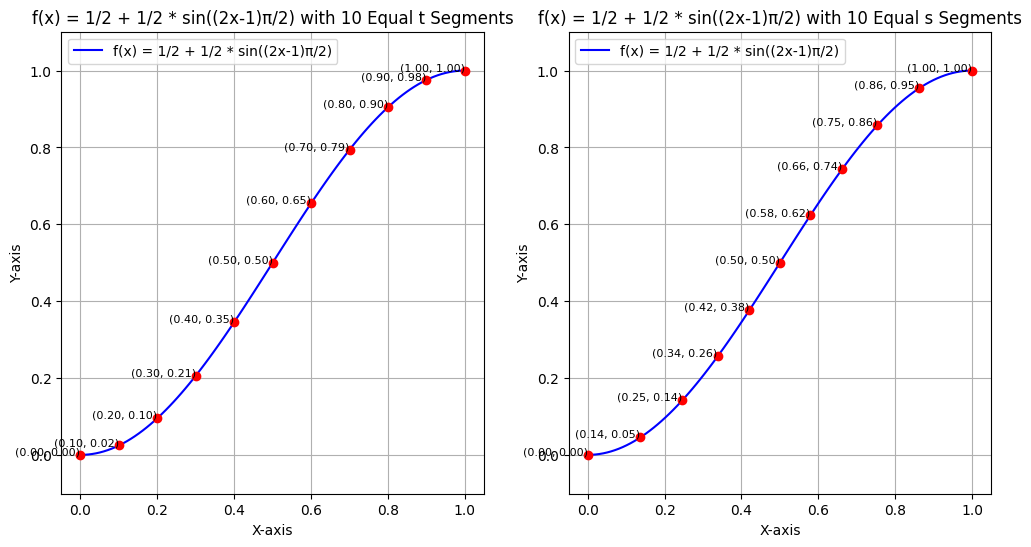

In [47]:
f = lambda t: np.array([t, 0.5 + 0.5 * np.sin((2*t - 1) * np.pi / 2)])
df = lambda t: np.array([1, np.pi / 2 * np.cos((2*t - 1) * np.pi / 2)])

motion_control = MotionControl(f, df, 'f(x) = 1/2 + 1/2 * sin((2x-1)π/2)')
# motion_control.plot_n_equal_segments(10)
# motion_control.plot_t_equal_segments(10)
motion_control.plot_t_left_s_right(10)